In [1]:
import time
import os
import random
import warnings
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import plotly.express as px
from data_cleaning import data_cleaning
from data_loader import ResNetTraditionalModel
import PIL

test_size = 0.15
seed = 9
scoring = "accuracy"

## Selecting Dataset

We are doing hyperparameter tuning on a small dataset and then use the parameter on the whole dataset

Then we are going to extract the image features' of images and store in a .mat file.

**If you have the .mat file already, you can skip this part**

In [2]:
data_cleaning(moeimouto=False, self_collected=True, force_write=True)

[STATUS] copying pics in data_set\self-collected\002_0_tohsaka_rin_official to data_set\modeling_data\tohsaka_rin
[STATUS] 002_0_tohsaka_rin_official copy work finished
[STATUS] copying pics in data_set\self-collected\003_0_mato_sakura_official to data_set\modeling_data\mato_sakura
[STATUS] 003_0_mato_sakura_official copy work finished
[STATUS] copying pics in data_set\self-collected\004_0_illyasviel_von_einzbern_official to data_set\modeling_data\illyasviel_von_einzbern
[STATUS] 004_0_illyasviel_von_einzbern_official copy work finished
[STATUS] copying pics in data_set\self-collected\005_0_rider_medusa_official to data_set\modeling_data\rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set\self-collected\006_0_misaka_mikoto_official to data_set\modeling_data\misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set\self-collected\007_0_violet_evergarden_official to data_set\modeling_data\vi

Extract the image features and store into a tf_s_dataset.mat

In [3]:
loader = ResNetTraditionalModel()
loader.write_data(file_name= "rf_s_dataset.mat")

[STATUS] Extract img color mean and std astolfo
[STATUS] Extract img color mean and std atalanta
[STATUS] Extract img color mean and std illyasviel_von_einzbern
[STATUS] Extract img color mean and std jeanne_darc
[STATUS] Extract img color mean and std mato_sakura
[STATUS] Extract img color mean and std misaka_mikoto
[STATUS] Extract img color mean and std mordred
[STATUS] Extract img color mean and std rider_medusa
[STATUS] Extract img color mean and std saber_arutoria_pendoragon
[STATUS] Extract img color mean and std tohsaka_rin
[STATUS] Extract img color mean and std violet_evergarden
[STATUS] Using device: cuda:0
[STATUS] 1/11 Processing astolfo
[STATUS] 2/11 Processing atalanta
[STATUS] 3/11 Processing illyasviel_von_einzbern
[STATUS] 4/11 Processing jeanne_darc
[STATUS] 5/11 Processing mato_sakura
[STATUS] 6/11 Processing misaka_mikoto
[STATUS] 7/11 Processing mordred
[STATUS] 8/11 Processing rider_medusa
[STATUS] 9/11 Processing saber_arutoria_pendoragon
[STATUS] 10/11 Processi

### load saved data

In [4]:
data = sio.loadmat(os.path.join('data_set', 'rf_s_dataset.mat'))

### normalize data

In [5]:
warnings.filterwarnings('ignore')
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['resnet_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train test split

In [6]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (1076, 1000)
Test data    : (191, 1000)
Train labels : (1076,)
Test labels  : (191,)


## Hyper parameter Tuning

### Logistic Regression:

1. Penalty Function

2. C

In [7]:
## Tuned result:
MAX_ITER = 10000 # tunned, no change after 100
TOL = 1e-4 # tunned, no change
C = 1.1 # tunned

In [8]:
# Penalty Function
list_p = ["l2", "none"]
list_c = np.linspace(1, 2.4, 15)

p_models = dict()

for i in list_p:
    p_models[i] = dict()
    for c in list_c:
        p_models[i][c] =  LogisticRegression(penalty=i, max_iter=MAX_ITER, random_state=seed,
                                             tol=TOL, C=c, warm_start=True)

p_results = {'l2': [], "none": []}
p_names = {'l2': [], "none": []}

for penalty in p_models:
    for name, model in p_models[penalty].items():
        since = time.time()
        kf = KFold(n_splits=4, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        p_results[penalty].append(cv_results)
        p_names[penalty].append(name)
        print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name,
                                                                                     cv_results.mean(),
                                                                                     cv_results.std()))
        time_elapsed = time.time() - since
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                                       time_elapsed % 60))

[CROSS_VAL_SCORE] Training 1.0 : accuracy: 0.914, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 1.1 : accuracy: 0.912, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 1.2 : accuracy: 0.912, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 1.3 : accuracy: 0.911, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 1.4 : accuracy: 0.911, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training 1.5 : accuracy: 0.911, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 1.6 : accuracy: 0.912, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 1.7 : accuracy: 0.912, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training 1.7999999999999998 : accuracy: 0.912, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training 1.9 : accuracy: 0.913, std: 0.021
[TIME_CONSUMPTION] Finishing in 0

Visualization of Penalty function selection

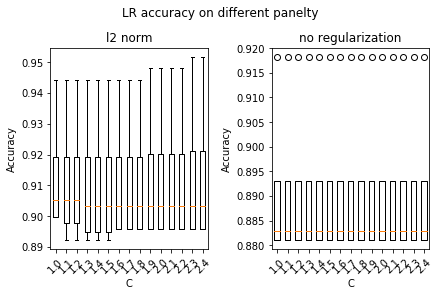

In [9]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(1, 2)
fig.suptitle('LR accuracy on different panelty')
ax1 = fig.add_subplot(gs[0,0])
plt.boxplot(p_results['l2'])
ax1.set_xticklabels(["{:.1f}".format(x) for x in p_names['l2']])
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.title("l2 norm")
ax2 = fig.add_subplot(gs[0,1])
plt.boxplot(p_results['none'])
ax2.set_xticklabels(["{:.1f}".format(x) for x in p_names['none']])
plt.xticks(rotation=45)
plt.title("no regularization")
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.savefig("project_document/images/res_tradi_LR_panelty")
plt.show()

tuning: regulization strength C

In [10]:
list_i = np.linspace(.1, 10., 100)

c_models = {i: LogisticRegression(max_iter=MAX_ITER, random_state=seed, tol=TOL, C=i, warm_start=True)
            for i in np.linspace(.1, 10, 100)}

lr_c_results = []
lr_c_names = []

for name in c_models:
    since = time.time()
    model = c_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    lr_c_results.append(cv_results)
    lr_c_names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training 0.1 : accuracy: 0.899, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 0.2 : accuracy: 0.905, std: 0.013
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training 0.30000000000000004 : accuracy: 0.910, std: 0.014
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 0.4 : accuracy: 0.913, std: 0.017
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 0.5 : accuracy: 0.914, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 0.6 : accuracy: 0.914, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 0.7000000000000001 : accuracy: 0.915, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 0.8 : accuracy: 0.914, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 0.9 : accuracy: 0.914, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training 1.0 : accuracy: 0.914, std: 0.018
[TIME_CONSUMPTION

[CROSS_VAL_SCORE] Training 8.1 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training 8.2 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training 8.3 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training 8.4 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training 8.5 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training 8.6 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training 8.7 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training 8.8 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training 8.9 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training 9.0 : accuracy: 0.911, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL

visualization of regulization strength C

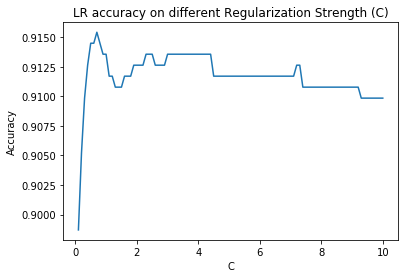

In [12]:
# fig = plt.figure()
# fig.suptitle('Machine Learning algorithm comparison on training set')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.xticks(rotation=-45)
# plt.show()

accuracies = [r.mean() for r in lr_c_results]
plt.plot(list_i, accuracies)
plt.title('LR accuracy on different Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.savefig("project_document/images/res_tradi_LR_C")
plt.show()

### KNN hyperparam tunning

turning: K

In [13]:
list_i = range(1, 30)

k_models = {k: KNeighborsClassifier(n_neighbors=k) for k in list_i}

knn_k_results = []
knn_k_names = []

for name in k_models:
    since = time.time()
    model = k_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    knn_k_results.append(cv_results)
    knn_k_names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    

[CROSS_VAL_SCORE] Training 1 : accuracy: 0.777, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2 : accuracy: 0.754, std: 0.019
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 3 : accuracy: 0.799, std: 0.008
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 4 : accuracy: 0.803, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 5 : accuracy: 0.821, std: 0.013
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 6 : accuracy: 0.805, std: 0.008
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 7 : accuracy: 0.810, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8 : accuracy: 0.804, std: 0.007
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 9 : accuracy: 0.806, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 10 : accuracy: 0.804, std: 0.007
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 11

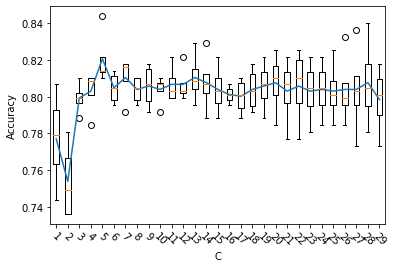

Best k = 5, accuracy = 0.820631970260223


In [16]:
fig = plt.figure()
# fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(knn_k_results)
ax.set_xticklabels(knn_k_names)
plt.xticks(rotation=-45)
# plt.show()

accuracies = [r.mean() for r in knn_k_results]
plt.plot(list_i, accuracies)
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.savefig("project_document/images/res_tradi_KNN")
plt.show()
print("Best k = {}, accuracy = {}"
      .format(list_i[np.array(accuracies).argmax()], np.array(accuracies).max()))

### Random Forest

1. Error function
2. n_estimators

Tuning error function:

In [17]:
rf_gini_acc = []
rf_gini_time_list = []
rf_entropy_acc = []
rf_entropy_time_list = []
rf_loss_f_n_list = np.hstack([np.array([10,50,100,500]),np.linspace(600,1500,num=5)])
for n in rf_loss_f_n_list:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training gini, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_gini_time_list.append(time_elapsed)
    rf_gini_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='entropy')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training entropy, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_entropy_time_list.append(time_elapsed)
    rf_entropy_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training gini, n_estimators: 10.0, accuracy: 0.655, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 10.0, accuracy: 0.650, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training gini, n_estimators: 50.0, accuracy: 0.791, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 50.0, accuracy: 0.793, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training gini, n_estimators: 100.0, accuracy: 0.812, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 100.0, accuracy: 0.807, std: 0.019
[TIME_CONSUMPTION] Finishing in 0m 10s
[CROSS_VAL_SCORE] Training gini, n_estimators: 500.0, accuracy: 0.836, std: 0.014
[TIME_CONSUMPTION] Finishing in 0m 19s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 500.0, accuracy: 0.831, std: 0.017
[TIME_CONSUMPTION] Finishing in 0m 52s
[CROSS_VAL_SCORE] Training gi

visualization of error function tunning

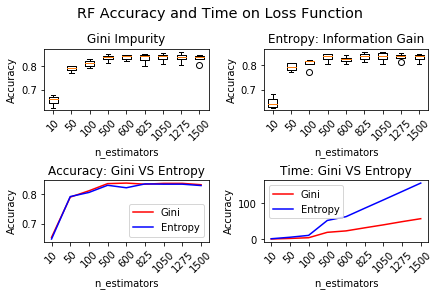

In [18]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(6, 2)
fig.suptitle('RF Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0:3,0])
plt.boxplot(rf_gini_acc)
ax1.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Gini Impurity')
plt.xticks(rotation=45, horizontalalignment="center")
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')

ax2 = fig.add_subplot(gs[0:3,1 ])
plt.boxplot(rf_entropy_acc)
ax2.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Entropy: Information Gain')
plt.xticks(rotation=45, horizontalalignment="center")
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')

ax3 = fig.add_subplot(gs[3:6,0])
plt.title('Accuracy: Gini VS Entropy')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], [x.mean() for x in rf_gini_acc], c='r', label='Gini')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], [x.mean() for x in rf_entropy_acc], c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')

ax3 = fig.add_subplot(gs[3:6,1])
plt.title('Time: Gini VS Entropy')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], rf_gini_time_list, c='r', label='Gini')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], rf_entropy_time_list, c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')

plt.savefig("project_document/images/res_tradi_RF_penalty")
plt.show()

tunning number of trees: n_estimators

In [19]:
acc = []
time_list = []
n_list_2 = np.hstack([np.array([10,50,100,500]),np.linspace(600,1400,num=5),np.array([3000,5000])])
for n in n_list_2:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training n_estimators: {} : accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    time_list.append(time_elapsed)
    acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


[CROSS_VAL_SCORE] Training n_estimators: 10.0 : accuracy: 0.638, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training n_estimators: 50.0 : accuracy: 0.785, std: 0.007
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training n_estimators: 100.0 : accuracy: 0.823, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training n_estimators: 500.0 : accuracy: 0.840, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 19s
[CROSS_VAL_SCORE] Training n_estimators: 600.0 : accuracy: 0.843, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 23s
[CROSS_VAL_SCORE] Training n_estimators: 800.0 : accuracy: 0.839, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 31s
[CROSS_VAL_SCORE] Training n_estimators: 1000.0 : accuracy: 0.836, std: 0.017
[TIME_CONSUMPTION] Finishing in 0m 38s
[CROSS_VAL_SCORE] Training n_estimators: 1200.0 : accuracy: 0.838, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 46s
[CROSS_VAL_SCORE] Training n_estimators: 1400.0 : accuracy: 0.835, std: 0.0

visualzation of n_estimators

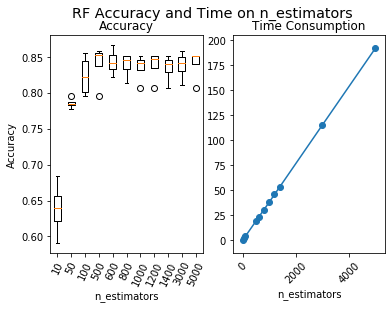

In [20]:
fig = plt.figure()
fig.suptitle("RF Accuracy and Time on n_estimators", fontsize='x-large')
ax = fig.add_subplot(121)
plt.boxplot(acc)
ax.set_xticklabels([int(x) for x in n_list_2])
plt.xticks(rotation=65, horizontalalignment="center")
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.title('Accuracy')

ax = fig.add_subplot(1,2,2)
ax.plot([int(x) for x in n_list_2], time_list)
ax.scatter([int(x) for x in n_list_2], time_list)
plt.xticks(rotation=45, horizontalalignment="center")
plt.xlabel('n_estimators')
plt.title('Time Consumption')

plt.savefig("project_document/images/res_tradi_RF_n_estimators")
plt.show()

### SVM
1. Loss Function
2. C
3. poly degree

Tunning: loss function

In [21]:
svm_ker_acc = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_time_list = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_n_list = np.hstack([np.linspace(1,5,5),8,10,20,50,100])
for c in svm_ker_n_list:
    for ker in ["linear", "poly", 'rbf', 'sigmoid']:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel=ker, C=c, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(ker,c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_ker_time_list[ker].append(time_elapsed)
        svm_ker_acc[ker].append(cv_results)
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: linear, C = 1.0, accuracy: 0.907, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly, C = 1.0, accuracy: 0.911, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 1.0, accuracy: 0.910, std: 0.008
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 1.0, accuracy: 0.123, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training kernal: linear, C = 2.0, accuracy: 0.907, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly, C = 2.0, accuracy: 0.911, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 2.0, accuracy: 0.915, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 2.0, accuracy: 0.123, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training kernal: linear, C = 3.0, accuracy: 0.

Visualization of loss function tunning

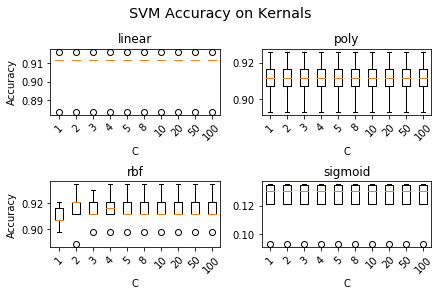

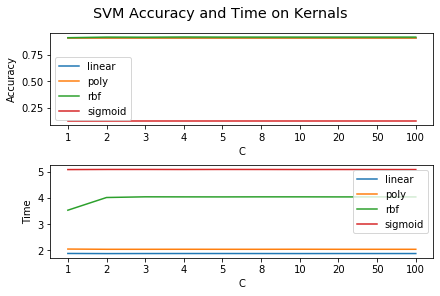

In [22]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
fig.suptitle('SVM Accuracy on Kernals', fontsize='x-large')

for i, key in enumerate(svm_ker_acc.keys()):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    plt.boxplot(svm_ker_acc[key])
    ax.set_xticklabels([int(x) for x in svm_ker_n_list])
    if i%2 == 0:
        plt.ylabel('Accuracy')
    plt.xlabel('C')
    plt.title(key)
    plt.xticks(rotation=45, horizontalalignment="center")
plt.savefig("project_document/images/res_tradi_SVM_penalty")
plt.show()



fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2)
fig.suptitle('SVM Accuracy and Time on Kernals', fontsize='x-large')

ax1 = fig.add_subplot(gs[0,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax1.plot([str(int(x)) for x in svm_ker_n_list], [x.mean() for x in svm_ker_acc[key]], label=key)
plt.ylabel('Accuracy')
plt.xlabel('C')
ax1.legend()

ax2 = fig.add_subplot(gs[1,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax2.plot([str(int(x)) for x in svm_ker_n_list], svm_ker_time_list[key], label=key)
plt.ylabel('Time')
plt.xlabel('C')
ax2.legend()
plt.savefig("project_document/images/res_tradi_SVM_penalty2")

plt.show()

## Use poly

Selected polynomial penalty function.

tunning degree and regularizaion strength C:

In [23]:
# C of poly
# degree for poly
svm_c_list = np.linspace(1,5,5)
svm_degree_list = range(1,15)
svm_shape = (len(svm_c_list), len(svm_degree_list))
svm_acc = pd.DataFrame(np.zeros(svm_shape))
svm_acc.columns = svm_degree_list
svm_acc.index = svm_c_list
svm_time = pd.DataFrame(np.zeros(svm_shape))
svm_time.columns = svm_degree_list
svm_time.index = svm_c_list

for degree in svm_degree_list:
    for c in svm_c_list:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel='poly', C=c, degree=degree, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: poly,degree = {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(degree, c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_acc.loc[c, degree] = cv_results.mean()
        svm_time.loc[c, degree] = time_elapsed
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 1.0, accuracy: 0.909, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 2.0, accuracy: 0.906, std: 0.013
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 3.0, accuracy: 0.909, std: 0.011
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 4.0, accuracy: 0.909, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 5.0, accuracy: 0.911, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 2, C = 1.0, accuracy: 0.914, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 2, C = 2.0, accuracy: 0.914, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 2, C = 3.0, accuracy: 0.914, std: 0.012
[TIME_CONSUMPTION] Fin

[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 1.0, accuracy: 0.914, std: 0.010
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 2.0, accuracy: 0.914, std: 0.010
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 3.0, accuracy: 0.914, std: 0.010
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 4.0, accuracy: 0.914, std: 0.010
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 5.0, accuracy: 0.914, std: 0.010
[TIME_CONSUMPTION] Finishing in 0m 3s


visualziation of c and degree

In [24]:
x_acc = []
y_acc = []
z_acc = []
for degree in svm_degree_list:
    for c in svm_c_list:
        x_acc.append(degree)
        y_acc.append(c)
        z_acc.append(svm_acc.loc[c, degree])
# z_acc_sigmoid = 1 / (1 + np.exp(-1 * np.array(z_acc)))
x_time = []
y_time = []
z_time = []
for degree in svm_degree_list:
    for c in svm_c_list:
        x_time.append(degree)
        y_time.append(c)
        z_time.append(svm_time.loc[c, degree])
# z_time_sigmoid = 1 / (1 + np.exp(-1 * np.array(z_time)))

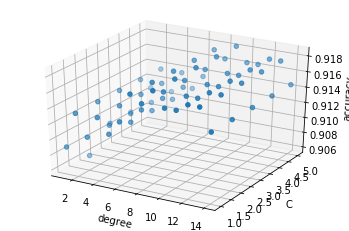

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_acc, y_acc, z_acc, marker='o')
ax.set_xlabel('degree')
ax.set_ylabel('C')
ax.set_zlabel('accuracy')
plt.show()

In [26]:
df_acc = pd.DataFrame({
    'degree': x_acc,
    'C': y_acc,
    'accuracy': z_acc
})
fig = px.scatter_3d(df_acc, x='degree', y='C', z='accuracy', color='accuracy', size='accuracy', size_max=13)
fig.show()

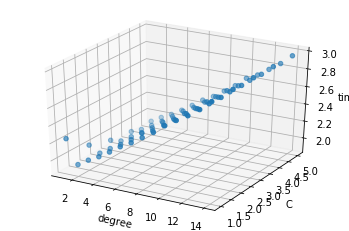

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_time, y_time, z_time, marker='o')
ax.set_xlabel('degree')
ax.set_ylabel('C')
ax.set_zlabel('time')
plt.show()

In [28]:
df_time = pd.DataFrame({
    'degree': x_time,
    'C': y_time,
    'time': z_time
})
fig = px.scatter_3d(df_time, x='degree', y='C', z='time', color='time', size_max=13)
fig.show()

In [29]:
i = np.array(z_acc).argmax()
svm_c = y_acc[i]
svm_degree = x_acc[i]
print("C = {}, degree = {}".format(svm_c, svm_degree))

C = 1.0, degree = 9


In [31]:
# Logistic Regreession
lr_c = 0.9
# Knn
knn_k = 5
# rf
num_trees = 600
rf_loss_func='gini'
# svm
svm_c = 1
svm_degree = 9

[CROSS_VAL_SCORE] Training LR : accuracy: 0.912, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 3s
[CROSS_VAL_SCORE] Training LDA : accuracy: 0.890, std: 0.009
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training KNN : accuracy: 0.804, std: 0.007
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training CART : accuracy: 0.522, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training RF : accuracy: 0.831, std: 0.019
[TIME_CONSUMPTION] Finishing in 0m 23s
[CROSS_VAL_SCORE] Training NB : accuracy: 0.782, std: 0.013
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training SVM : accuracy: 0.909, std: 0.014
[TIME_CONSUMPTION] Finishing in 0m 2s


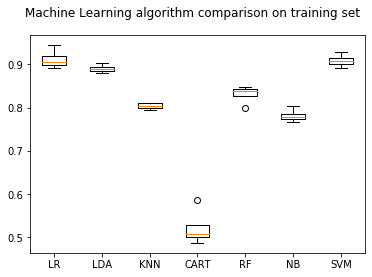

In [32]:
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.0001, C=1.1, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(n_neighbors = 8),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, criterion=rf_loss_func, warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed, kernel='poly', C=svm_c, degree=svm_degree, decision_function_shape='ovo')}

results = []
names = []

for name in models.keys():
    since = time.time()
    model = models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Train the models and see the accuracy rate on both training and testing set

In [33]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[RESULT] LR accuracy on training set: 1.000
[RESULT] LR accuracy on testing set: 0.911
[TIME_CONSUMPTION] Finishing in 0m 1s
[RESULT] LDA accuracy on training set: 1.000
[RESULT] LDA accuracy on testing set: 0.927
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] KNN accuracy on training set: 0.891
[RESULT] KNN accuracy on testing set: 0.859
[TIME_CONSUMPTION] Finishing in 0m 2s
[RESULT] CART accuracy on training set: 1.000
[RESULT] CART accuracy on testing set: 0.503
[TIME_CONSUMPTION] Finishing in 0m 1s
[RESULT] RF accuracy on training set: 1.000
[RESULT] RF accuracy on testing set: 0.843
[TIME_CONSUMPTION] Finishing in 0m 8s
[RESULT] NB accuracy on training set: 0.839
[RESULT] NB accuracy on testing set: 0.775
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] SVM accuracy on training set: 1.000
[RESULT] SVM accuracy on testing set: 0.911
[TIME_CONSUMPTION] Finishing in 0m 1s


### Best model:
We build some examples using LDA.

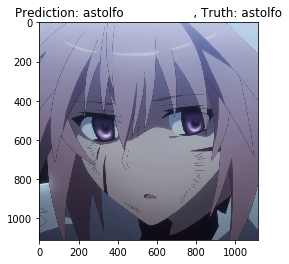

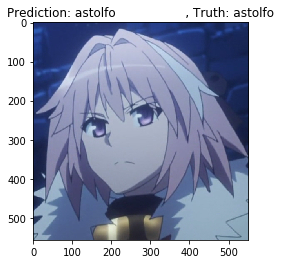

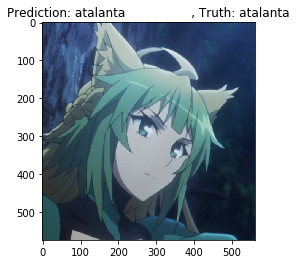

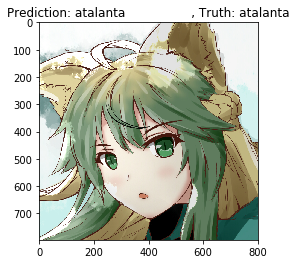

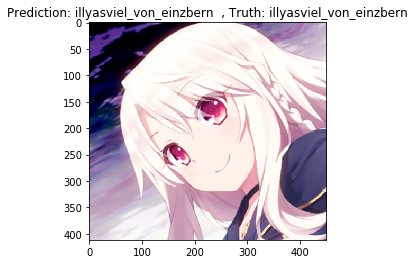

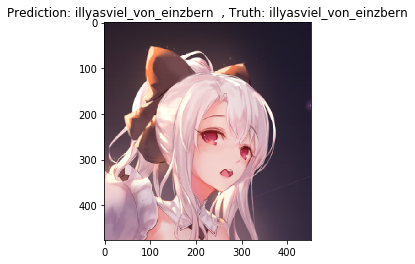

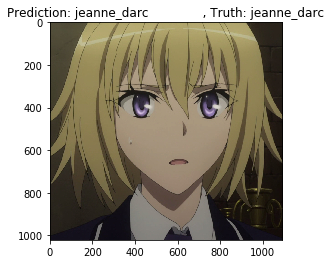

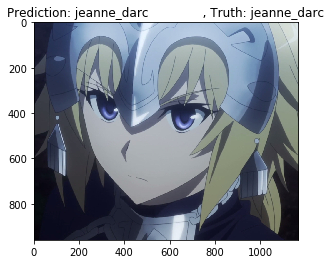

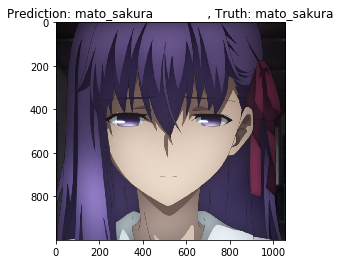

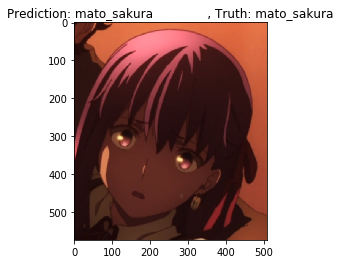

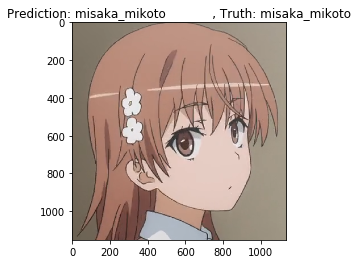

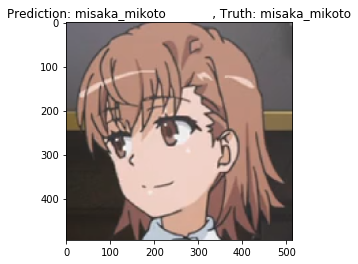

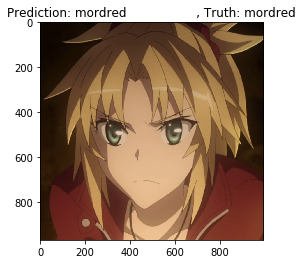

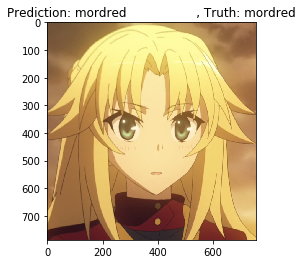

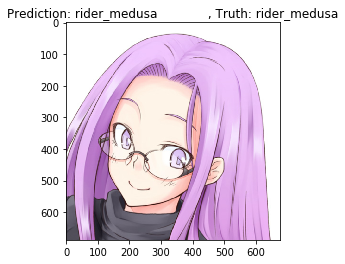

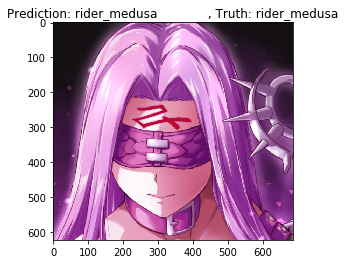

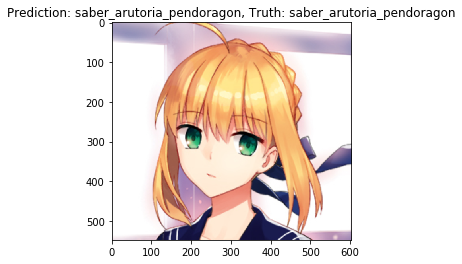

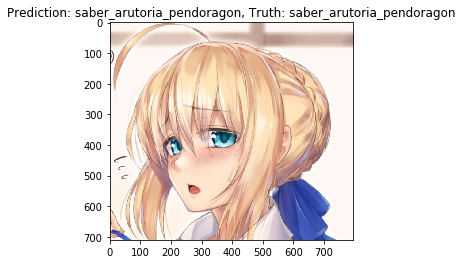

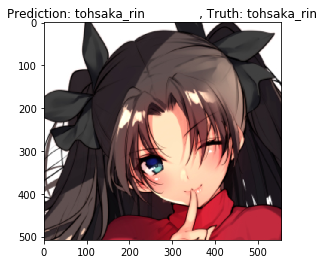

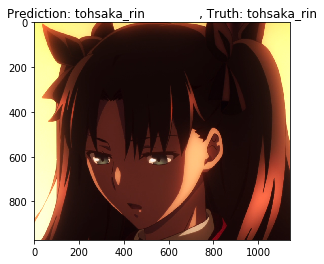

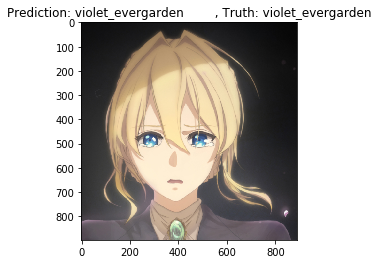

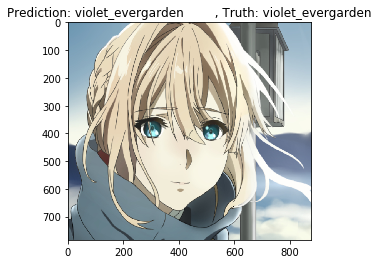

In [34]:
best_model = models['LR']

modeling_data_path = os.path.join('data_set', 'modeling_data')
characters_folders = os.listdir(modeling_data_path)
for character in characters_folders:
    pic_folder = os.path.join(modeling_data_path, character)
    all_pics = os.listdir(pic_folder)
    sampling = random.choices(all_pics, k=2)
    for pic in sampling:
        pic_dir = os.path.join(pic_folder, pic)
        image = PIL.Image.open(pic_dir).convert('RGB')
        pic_feature = loader.single_image_to_vec(image)
        pic_feature = normalizer.transform(np.array([pic_feature]))
        # print(pic_feature.shape)
        pred_result = best_model.predict(pic_feature)[0]
        pred_result = name_label_map[pred_result]
        # print(pred_result)
        plt.imshow(image)
        plt.title("Prediction: {}, Truth: {}".format(pred_result, character))
        plt.show()

### Confusion Matrix

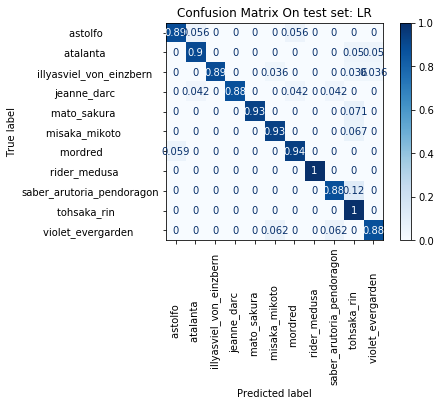

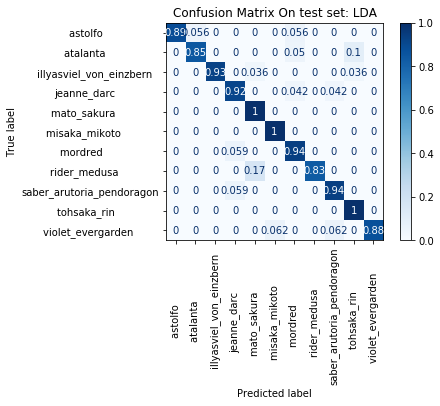

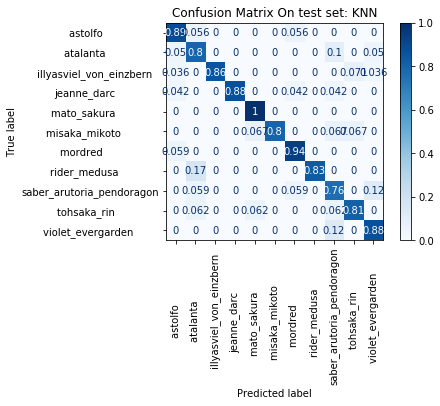

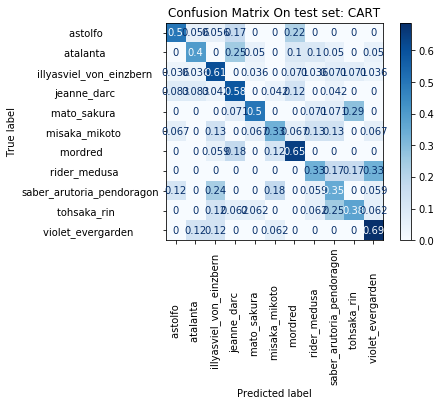

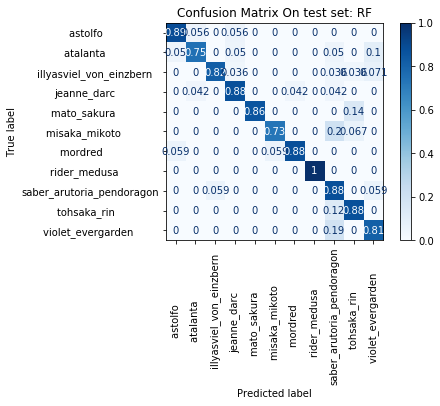

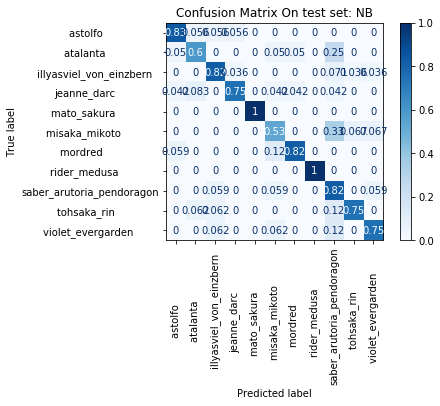

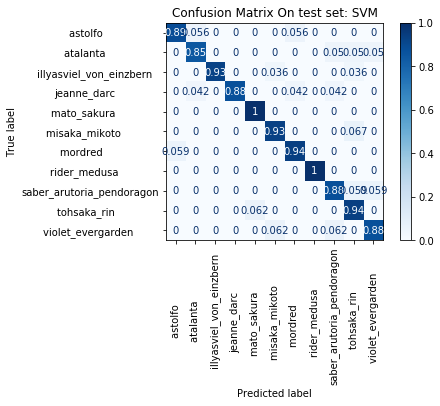

In [35]:
for key in models.keys():
    model = models[key]
    disp = plot_confusion_matrix(model, fv_tst, fv_l_tst,
                                 display_labels=name_label_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.xticks(rotation='vertical', horizontalalignment="center")
    disp.ax_.set_title("Confusion Matrix On test set: {}".format(key))
    if key == 'LR':
        plt.savefig("project_document/images/res_tradi_cm_LR")
    plt.show()

## Training on whole Dataset

### Warning: code blocks below may take a long time / large memory to run.

Since code blocks below will run models on the whole dataset, python kernel may be killed due to lack of memory when running memory heavy models like random-forest classifier. These code blocks are here for testing final prediction result.


### switching and reencode the dataset

In [36]:
data_cleaning(True, True, destination="whole_data", force_write=True)
loader = ResNetTraditionalModel(data_path='data_set/whole_data')
loader.write_data(file_name='rf_l_dataset.mat',)

[STATUS] copying pics in data_set\moeimouto-faces-filtered\000_hatsune_miku to data_set\whole_data\hatsune_miku
[STATUS] 000_hatsune_miku copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\001_kinomoto_sakura to data_set\whole_data\kinomoto_sakura
[STATUS] 001_kinomoto_sakura copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\002_suzumiya_haruhi to data_set\whole_data\suzumiya_haruhi
[STATUS] 002_suzumiya_haruhi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\003_fate_testarossa to data_set\whole_data\fate_testarossa
[STATUS] 003_fate_testarossa copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\004_takamachi_nanoha to data_set\whole_data\takamachi_nanoha
[STATUS] 004_takamachi_nanoha copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\006_akiyama_mio to data_set\whole_data\akiyama_mio
[STATUS] 006_akiyama_mio copy work finished
[STATUS] copying pics 

[STATUS] 056_nagi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\058_kochiya_sanae to data_set\whole_data\kochiya_sanae
[STATUS] 058_kochiya_sanae copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\059_sairenji_haruna to data_set\whole_data\sairenji_haruna
[STATUS] 059_sairenji_haruna copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\060_ichinose_kotomi to data_set\whole_data\ichinose_kotomi
[STATUS] 060_ichinose_kotomi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\061_furude_rika to data_set\whole_data\furude_rika
[STATUS] 061_furude_rika copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\062_matou_sakura to data_set\whole_data\matou_sakura
[STATUS] 062_matou_sakura copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\063_ryuuguu_rena to data_set\whole_data\ryuuguu_rena
[STATUS] 063_ryuuguu_rena copy work finished
[ST

[STATUS] 129_primula copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\131_belldandy to data_set\whole_data\belldandy
[STATUS] 131_belldandy copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\132_minamoto_chizuru to data_set\whole_data\minamoto_chizuru
[STATUS] 132_minamoto_chizuru copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\134_nunnally_lamperouge to data_set\whole_data\nunnally_lamperouge
[STATUS] 134_nunnally_lamperouge copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\136_shirley_fenette to data_set\whole_data\shirley_fenette
[STATUS] 136_shirley_fenette copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\137_sonsaku_hakufu to data_set\whole_data\sonsaku_hakufu
[STATUS] 137_sonsaku_hakufu copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\138_kanu to data_set\whole_data\kanu
[STATUS] 138_kanu copy work finished
[ST

[STATUS] 004_0_illyasviel_von_einzbern_official copy work finished
[STATUS] copying pics in data_set\self-collected\005_0_rider_medusa_official to data_set\whole_data\rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set\self-collected\006_0_misaka_mikoto_official to data_set\whole_data\misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set\self-collected\007_0_violet_evergarden_official to data_set\whole_data\violet_evergarden
[STATUS] 007_0_violet_evergarden_official copy work finished
[STATUS] copying pics in data_set\self-collected\008_1_mordred_official to data_set\whole_data\mordred
[STATUS] 008_1_mordred_official copy work finished
[STATUS] copying pics in data_set\self-collected\009_1_jeanne_darc_official to data_set\whole_data\jeanne_darc
[STATUS] 009_1_jeanne_darc_official copy work finished
[STATUS] copying pics in data_set\self-collected\010_1_atalanta_official to data_set\who

[STATUS] Extract img color mean and std nogizaka_haruka
[STATUS] Extract img color mean and std noumi_kudryavka
[STATUS] Extract img color mean and std nunnally_lamperouge
[STATUS] Extract img color mean and std ogasawara_sachiko
[STATUS] Extract img color mean and std pastel_ink
[STATUS] Extract img color mean and std patchouli_knowledge
[STATUS] Extract img color mean and std primula
[STATUS] Extract img color mean and std ranka_lee
[STATUS] Extract img color mean and std reina
[STATUS] Extract img color mean and std reinforce_zwei
[STATUS] Extract img color mean and std reisen_udongein_inaba
[STATUS] Extract img color mean and std remilia_scarlet
[STATUS] Extract img color mean and std rider_medusa
[STATUS] Extract img color mean and std ryougi_shiki
[STATUS] Extract img color mean and std ryuuguu_rena
[STATUS] Extract img color mean and std saber_arutoria_pendoragon
[STATUS] Extract img color mean and std saigyouji_yuyuko
[STATUS] Extract img color mean and std sairenji_haruna
[STA

[STATUS] 122/166 Processing saigyouji_yuyuko
[STATUS] 123/166 Processing sairenji_haruna
[STATUS] 124/166 Processing sakagami_tomoyo
[STATUS] 125/166 Processing sanzenin_nagi
[STATUS] 126/166 Processing saotome_alto
[STATUS] 127/166 Processing sendou_erika
[STATUS] 128/166 Processing seto_san
[STATUS] 129/166 Processing shameimaru_aya
[STATUS] 130/166 Processing shana
[STATUS] 131/166 Processing sheryl_nome
[STATUS] 132/166 Processing shidou_hikaru
[STATUS] 133/166 Processing shigure_asa
[STATUS] 134/166 Processing shihou_matsuri
[STATUS] 135/166 Processing shindou_chihiro
[STATUS] 136/166 Processing shindou_kei
[STATUS] 137/166 Processing shinku
[STATUS] 138/166 Processing shirakawa_kotori
[STATUS] 139/166 Processing shirley_fenette
[STATUS] 140/166 Processing siesta
[STATUS] 141/166 Processing sonozaki_mion
[STATUS] 142/166 Processing sonsaku_hakufu
[STATUS] 143/166 Processing souryuu_asuka_langley
[STATUS] 144/166 Processing subaru_nakajima
[STATUS] 145/166 Processing suigintou
[STA

### load data

In [2]:
data = sio.loadmat(os.path.join('data_set', 'rf_l_dataset.mat'))

### normalize data

In [3]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['resnet_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train Test Split

In [4]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (12133, 1000)
Test data    : (2142, 1000)
Train labels : (12133,)
Test labels  : (2142,)


In [5]:
# Logistic Regreession
lr_c = 0.9
# Knn
knn_k = 5
# rf
num_trees = 600
rf_loss_func='gini'
# svm
svm_c = 1
svm_degree = 9

In [7]:
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.0001, C=lr_c, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(n_neighbors = knn_k),
          'CART': DecisionTreeClassifier(),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed, kernel='poly', C=svm_c, degree=svm_degree, decision_function_shape='ovo')}
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[RESULT] LR accuracy on training set: 0.930
[RESULT] LR accuracy on testing set: 0.707
[TIME_CONSUMPTION] Finishing in 2m 10s
[RESULT] LDA accuracy on training set: 0.919
[RESULT] LDA accuracy on testing set: 0.756
[TIME_CONSUMPTION] Finishing in 0m 2s
[RESULT] KNN accuracy on training set: 0.653
[RESULT] KNN accuracy on testing set: 0.420
[TIME_CONSUMPTION] Finishing in 3m 51s
[RESULT] CART accuracy on training set: 0.998
[RESULT] CART accuracy on testing set: 0.140
[TIME_CONSUMPTION] Finishing in 1m 44s
[RESULT] NB accuracy on training set: 0.613
[RESULT] NB accuracy on testing set: 0.490
[TIME_CONSUMPTION] Finishing in 0m 27s
[RESULT] SVM accuracy on training set: 0.998
[RESULT] SVM accuracy on testing set: 0.697
[TIME_CONSUMPTION] Finishing in 3m 60s


In [ ]:
model = RandomForestClassifier(n_estimators=num_trees, random_state=seed, criterion=rf_loss_func, warm_start=True)
since = time.time()
model.fit(fv_trn, fv_l_trn)
pred = model.predict(fv_trn)
result = np.equal(pred, fv_l_trn)
accuracy = np.sum(result) / len(result)
print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
pred = model.predict(fv_tst)
result = np.equal(pred, fv_l_tst)
accuracy = np.sum(result) / len(result)
print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
time_elapsed = time.time() - since
print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))